In [1]:
# Imports of necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import the CMU movie datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

folder_path = os.path.abspath('MovieSummaries')

df_movies = pd.read_csv(os.path.join(folder_path, "movie.metadata.tsv"), delimiter='\t', names = movie_column_names)
df_summaries = pd.read_csv(os.path.join(folder_path, "plot_summaries.txt"), delimiter='\t', names=['Wikipedia_movie_ID', 'movie_summary'])

# 0) Get Dataset and subset

In [3]:
import preprocessing

In [5]:
df_movies, df_summaries = preprocessing.get_datasets()
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)

if os.path.exists('df_fictional_summaries.csv'):
    df_fictional_summaries = pd.read_csv('df_fictional_summaries.csv')
else:
    df_fictional_summaries = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries)
    df_fictional_summaries.to_csv('df_fictional_summaries.csv')

if os.path.exists("preprocessed_fictional_summaries.csv"):
    df_preprocessed_fictional_summaries = pd.read_csv("preprocessed_fictional_summaries.csv")

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural


# 0) Preprocess summaries

In [6]:
# import further necessary packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

## a) With nltk

In [ ]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [9]:
# Data sample as the previously defined subset of fictional summaries
sample_summaries = df_fictional_summaries.copy()

# Text preprocessing to remove Proper nouns (NPP)
def filter_names(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(token, pos=pos) if pos.startswith('N') else lemmatizer.lemmatize(token) for token, pos in tagged_tokens]
    
    return ' '.join(filtered_tokens)


# Preprocess the documents
preprocessed_summaries = [filter_names(doc) for doc in sample_summaries['movie_summary']]

# Takes up to 3-4 minutes

## b) with spacy

In [27]:
nlp = spacy.load("en_core_web_sm")

def filter_names_spacy_batch(docs):
    processed_docs = []
    for doc in nlp.pipe(docs, batch_size=100, disable=["tagger", "textcat"], n_process=6):
        filtered_tokens = [token.lemma_ for token in doc if token.pos_ != 'PROPN']
        processed_docs.append(' '.join(filtered_tokens))
    return processed_docs

preprocessed_summaries = filter_names_spacy_batch(df_fictional_summaries['movie_summary'])

In [28]:
preprocessed_summaries_df = df_fictional_summaries.copy().reset_index()
preprocessed_summaries_df['preprocessed_summary'] = preprocessed_summaries
preprocessed_summaries_df

# takes around 1min30

,index,Unnamed: 0,Wikipedia_movie_ID,movie_summary,preprocessed_summary
0,0,1,31186339,The nation of Panem consists of a wealthy Capi...,the nation of consist of a wealthy and twelve ...
1,1,49,1838882,"The evil Lord Conqueror, head of Conqueror's C...","the evil , head of 's , be give a prophecy by ..."
2,2,54,4466226,During the Great depression in 1933 in Winnipe...,"during the great depression in 1933 in , , an ..."
3,3,76,657446,"In Los Angeles, California Fletcher Reede is ...","in , be a career - focus lawyer and divorced..."
4,4,80,32163620,"In the winter of 1945, immediately after the l...","in the winter of 1945 , immediately after the ..."
...,...,...,...,...,...
3936,3936,42259,1883373,The following is a detailed overview of the mi...,the following be a detailed overview of the mi...
3937,3937,42264,24434156,"In the not too distant future, society has lev...","in the not too distant future , society have l..."
3938,3938,42276,20402406,"In the 13th century, three women accused of wi...","in the 13th century , three woman accuse of wi..."
3939,3939,42292,26261438,While drinking alone one night and reminiscing...,while drink alone one night and reminiscing of...


In [ ]:
save_csv = False
read_csv = True

if save_csv:
    preprocessed_summaries.to_csv('preprocessed_fictional_summaries.csv')
elif read_csv:
    preprocessed_sample_summaries = pd.read_csv("preprocessed_fictional_summaries.csv")

# Perform LDA on preprocessed summaries

In [104]:
# General parameters to adapt
n_features = 4000
n_topics = 15
n_top_words = 15

# Vectorize the summaries
vectorizer = CountVectorizer(max_df=0.50, min_df=5, max_features=n_features, stop_words="english")
#vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features)

dtm = vectorizer.fit_transform(preprocessed_summaries)

# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    doc_topic_prior= 0.05,
    topic_word_prior= 0.2,
    learning_method = 'online',
    max_iter=15,
    random_state=7,
    verbose=1
)

lda.fit(dtm)

# Define function to show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)

# Improve comprehension with adapted column and index names
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

# takes around 1min30 with 2000 features

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,egg,snake,rat,expedition,scientist,girl,jungle,cult,native,twin,ray,island,skull,plateau,viktor
Topic 1,ship,planet,alien,crew,space,destroy,human,use,mission,return,pilot,discover,attack,order,crash
Topic 2,child,tell,father,home,make,return,family,help,mother,house,boy,friend,turn,parent,love
Topic 3,car,truck,driver,race,drive,comet,chicken,bike,bus,raider,tire,film,ride,tomato,road
Topic 4,tell,man,leave,woman,night,come,say,ask,room,away,kill,appear,try,girl,run
Topic 5,town,kill,local,man,wife,dog,house,ghost,village,gang,family,woman,hunter,son,young
Topic 6,monster,island,giant,cave,dragon,water,creature,sea,boat,fly,come,animal,begin,dinosaur,fall
Topic 7,rocket,moon,soviet,capsule,launch,com,space,martian,lunar,russian,www,http,mission,film,18
Topic 8,formula,invisibility,antidote,stranger,epidemic,beach,tough,pound,concoct,fortune,bravery,pretty,spit,exact,mole
Topic 9,kill,escape,attack,creature,leave,shoot,alien,group,try,use,discover,arrive,run,body,make


In [103]:
dtm.shape

(3941, 8449)

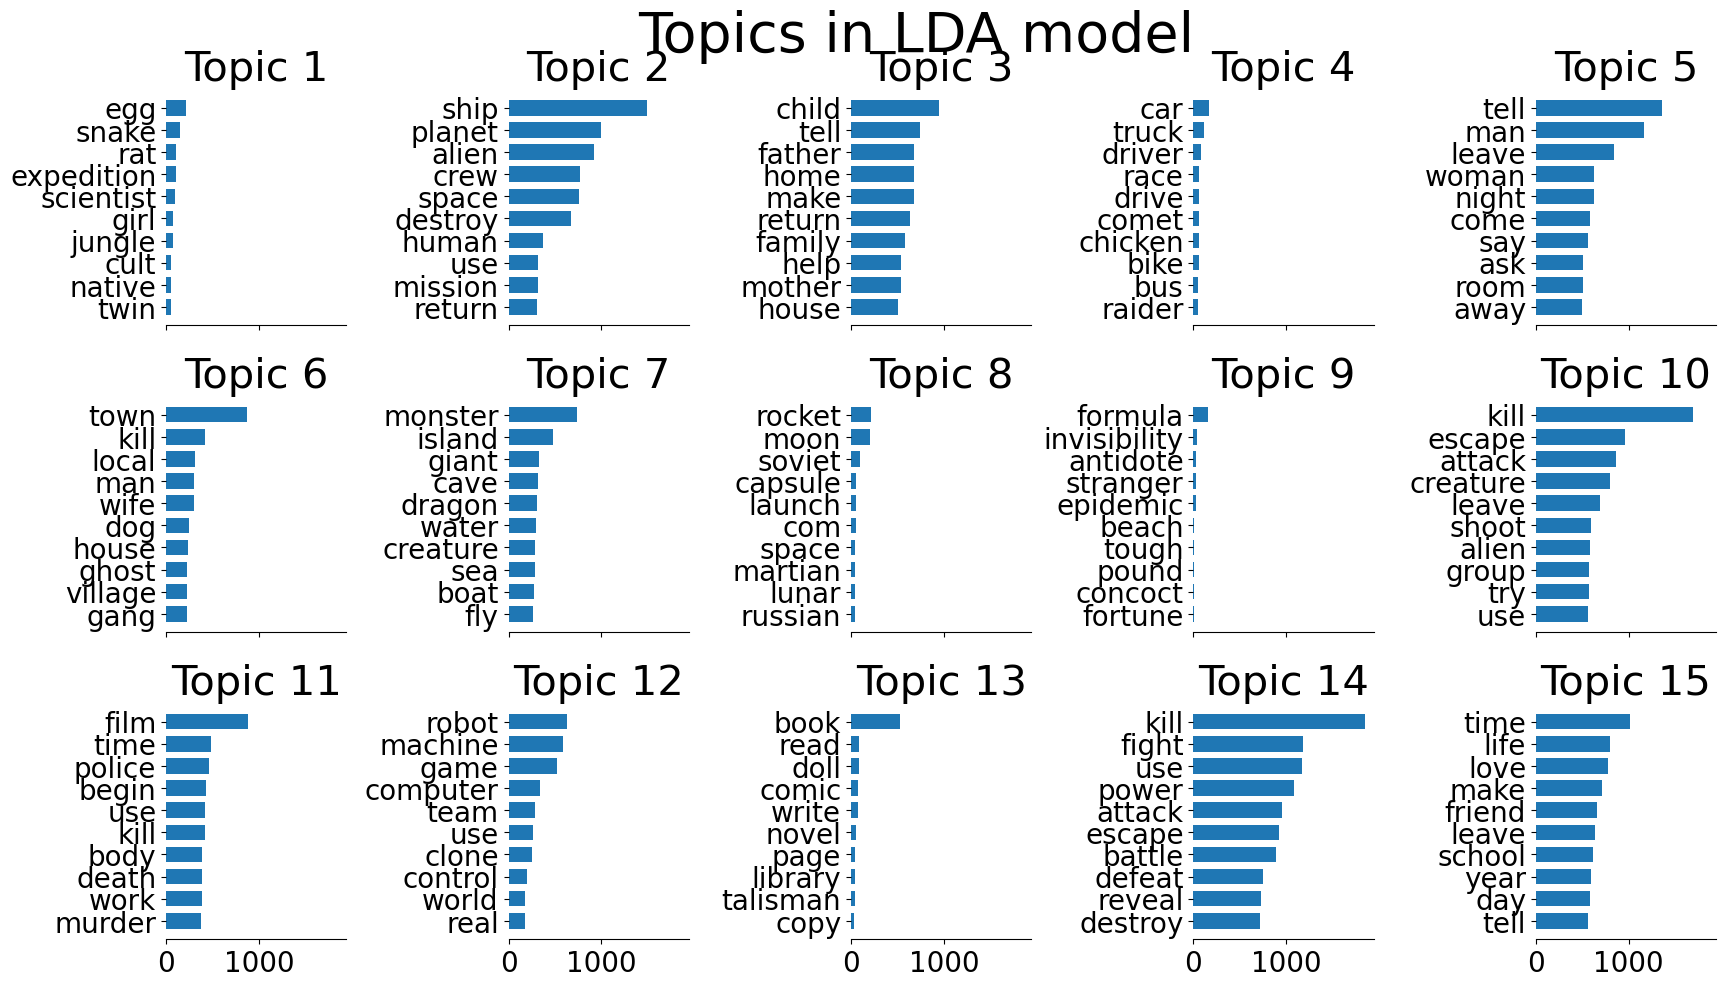

In [105]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    """
    Function to plot n top words for m topics as horizontals barplots with the measured weight.
    
    This function is taken and adapted from sklearn example at https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    # Get number of rows and columns to plot
    row_n = np.ceil(n_topics/5).astype(int)
    col_n = min([n_topics, 5])
    
    # Main figure with row_n x col_n subplots 
    fig, axes = plt.subplots(row_n, col_n, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # getting words and their weight from topics
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        # plot results as horizontal bars
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top n words for all topics
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, n_topics=n_topics, title="Topics in LDA model")

### Other: Topic coherence score

In [55]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

dictionary = Dictionary(topic_keywords)
bow_corpus = [dictionary.doc2bow(topic_words) for topic_words in topic_keywords]

cm = CoherenceModel(topics=topic_keywords, corpus=bow_corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence_per_topic()
coherence

[-0.6740974331817552,
 -0.4583656053663939,
 -0.20813774034919819,
 -0.40443264841248805,
 -0.44591725971630664,
 -0.2658032123004911,
 -0.32957374310384846,
 -0.34003671728106055,
 -0.026405606868474107,
 -0.7521925106205929]

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume lda is the fitted LatentDirichletAllocation model
# You should have already fit the model on your document-term matrix

# Get the top 15 words for each topic
num_top_words = 15
feature_names = lda.components_.argsort(axis=1)[:, :-num_top_words-1:-1]
feature_names.shape

(10, 15)

In [67]:
# Create vectors representing the word distributions for each topic
topic_vectors = None
for topic_words in feature_names:
    topic_vector = np.zeros(len(lda.components_[0]))
    topic_vector[topic_words] = 1
    if topic_vectors is None:
        topic_vectors = topic_vector
    else:
        topic_vectors = np.vstack((topic_vectors,topic_vector))

# Compute cosine similarity between two topics
topic1_index = 0 
topic2_index = 9
similarity = cosine_similarity([topic_vectors[topic1_index]], [topic_vectors[topic2_index]])

print(f"Cosine Similarity between Topic {topic1_index} and Topic {topic2_index}: {similarity[0][0]}")

(10, 3000)

In [99]:
# TO AVOID SPARSE MATRICES

def get_similarity_between_vectors(topic1_index = 0 , topic2_index = 9, feature_array=feature_names, tf_feature_names = None):

    topic1_word_ids = feature_array[topic1_index, :]
    topic2_word_ids = feature_array[topic2_index, :]
    combined_word_ids = np.hstack((topic1_word_ids, topic2_word_ids))
    if tf_feature_names is not None:
        # Print words associated to each topic (debug purpose)
        topic1_words = tf_feature_names[topic1_word_ids]
        topic2_words = tf_feature_names[topic2_word_ids]
        print(f"words of topic {topic1_index}: {topic1_words} and topic {topic2_index}: {topic2_words}")
    # Create binary vectors
    topic1_vector = np.isin(combined_word_ids, topic1_word_ids).astype(int)
    topic2_vector = np.isin(combined_word_ids, topic2_word_ids).astype(int)

    # Reshape to (1, 2 * num_top_words) for consistent shape
    topic1_vector = topic1_vector.reshape(1, -1)
    topic2_vector = topic2_vector.reshape(1, -1)

    # Compute cosine similarity
    similarity = cosine_similarity(topic1_vector, topic2_vector)
    print(f"Cosine Similarity between Topic {topic1_index} and Topic {topic2_index}: {similarity[0][0]:.3f}")
    return similarity
    
for i in range(10):
    get_similarity_between_vectors(1,i)

Cosine Similarity between Topic 1 and Topic 0: 0.235
Cosine Similarity between Topic 1 and Topic 1: 1.000
Cosine Similarity between Topic 1 and Topic 2: 0.000
Cosine Similarity between Topic 1 and Topic 3: 0.000
Cosine Similarity between Topic 1 and Topic 4: 0.000
Cosine Similarity between Topic 1 and Topic 5: 0.125
Cosine Similarity between Topic 1 and Topic 6: 0.500
Cosine Similarity between Topic 1 and Topic 7: 0.125
Cosine Similarity between Topic 1 and Topic 8: 0.000
Cosine Similarity between Topic 1 and Topic 9: 0.125


## Find topic related to movie

In [ ]:
fictional_summaries = sample_summaries.copy().reset_index()

In [49]:
topic_names = ['familiy', 'crime', 'worlwide_war', 'robot_science', 'time_travel', 'space', 'monster', 'creatures', 'vampires', 'fight_kings']

In [55]:
i = fictional_summaries.sample(1)

print(i['movie_summary'].values)
topic_distrib = lda.transform(dtm[i.index,:])
print(topic_distrib)
print(topic_names[topic_distrib.argmax()])

['Branded as a "nerd" and harassed by the school bully, twelve-year-old Arthur is rescued by a magical troll who knows that the boy unwittingly holds the secret to defeat an evil dragon. Arthur\'s loving mom, struggling to keep her devious ex-husband from gaining custody of Arthur, dismisses her son’s "fantasies" until she realizes the all too real immediate danger and joins forces with Arthur, the troll, and a dashing but washed up video-game master. Together, they hope to conquer the dragon and the wicked vice-principal who threaten civilization.']
[[0.41326681 0.00400058 0.00400092 0.0040011  0.00400054 0.00400166
  0.1229096  0.00400125 0.43581648 0.00400106]] vampires


In [62]:
vectorizer.inverse_transform(dtm[i.index,:])

[array(['boy', 'year', 'old', 'son', 'evil', 'defeat', 'game', 'ex',
        'knows', 'realizes', 'husband', 'secret', 'magical', 'real',
        'forces', 'dragon', 'holds', 'school', 'joins', 'master', 'video',
        'hope', 'rescued'], dtype='<U13')]